# Laboratory of Computational Physics mod.B

## Second assignment

### Group name: LoCPdown
### Components:
* Campesan Giulia (2027592)
* Faorlin Tommaso (2021857)
* Marcomini Alessandro (2024286)

### Objective:
The goal of this project is the analysis of various architectures of Deep Neural Networks (DNNs) and the characterization of how different parameters affects their performances. In particular, the dataset we work on is a sequence of $N=3000$ strings of sixteen characters indicating nucleic bases ('A', 'C', 'G', 'T') where a binary classification has been performed so to find a certain sequence of bases.

Here we import data and libraries. In order to perform suitable calculations an one-hot encoding technique has been adopted. 

In [1]:
#import libraries

import time
import math
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from google.colab import files

#importing the file of sequences
uploaded_files = files.upload()
fname = open('sequences16.csv', 'r')

Saving sequences16.csv to sequences16 (5).csv


In [2]:
#import data

sx, sy = np.loadtxt(fname,
                    delimiter=',',
                    usecols=(0,1),
                    unpack=True,
                    dtype=str
                    )
N=len(sy)
Ls=len(sx[0])

perc_train=0.7
N_train= int(N*perc_train)
N_test = N-N_train

print('Original dataset composition:')
print(f'\ndata: {N}\ntrain: {N_train}\ntest: {N_test}')

Original dataset composition:

data: 3000
train: 2100
test: 900


In [3]:
#one hot encoding

Q = ['A', 'C', 'G', 'T']
Nc=4
onehc={Q[i]: i for i in range(Nc)}

y = sy.astype(int)
L = Ls*Nc

x = np.zeros((N, L))

for n in range(N):
    for i in range(Ls):
        x[n][i*4 + onehc[sx[n][i]]] = 1 

## DNN definition, train and test

We now exploit the dataset we have to perform a full characterization of a DNN architecture. We firstly divide training and test sets and proceed to define the network architecture. In our case, we decide to implement a four-layers neural network with decreasing number of neurons and rectified linear units as internal activation functions. The one-neuron output function returns a probability density by using a sigmoid function.

In [4]:
x_train, y_train = x[:N_train], y[:N_train]
x_test, y_test = x[N_train:], y[N_train:]

score_train = y_train.sum()/len(y_train)
score_test = y_test.sum()/len(y_test)
print(score_train, score_test)

0.24714285714285714 0.24444444444444444


In [5]:
np.random.seed(123)

model = Sequential()
model.add(Dense(L, input_shape=(L,), activation='relu'))
model.add(Dense(L/2, activation='relu'))
model.add(Dense(L/4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None


We now compile our model using the binary cross entropy as loss function:
$$
H\left(y,\hat{y}\right) = -y\log\hat{y} - (1-y)\log\left(1-\hat{y}\right)
$$
where $\hat{y}$ is the true label and $y$ is the prediction. 

The gradient descent is performed over minibatches of size 50 and the optimizer is chosen to be ADAM. The number of epochs is set at 30. The graphs below report the trends of loss function and accuracy.

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='ADAM',
              metrics=['accuracy'])

fit = model.fit(x_train, y_train,
                epochs = 30,
                batch_size = 50,
                validation_data = (x_test, y_test),
                shuffle = True,
                verbose = 0
               )

score = model.evaluate(x_test, y_test, verbose=1)

# print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])

29/29 [==============================] - 0s 2ms/step - loss: 0.9657 - accuracy: 0.7800
Test loss: 0.9657472968101501
Test accuracy: 0.7799999713897705


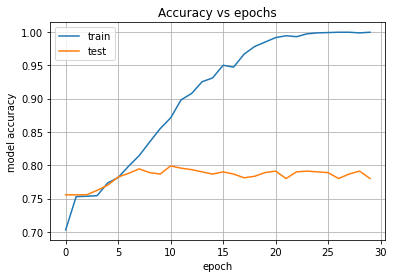

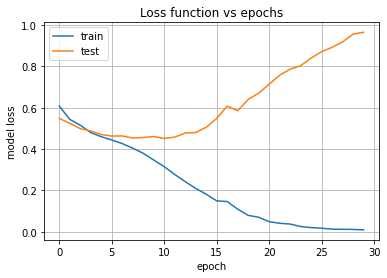

In [7]:
#Plot

# accuracy
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('Accuracy vs epochs')
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()
# loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Loss function vs epochs')
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

As shown by the graphs above, there is a clear overfitting phenomenon due to the small size of the training set with respect to the amount of parameters of the DNN. In fact, we notice that the training error decreases sistematically until reaching almost zero, while the test error diverges and at the end of the process is greatly different from the training one.

## Data augmentation

Since the predictive power of our network is rather limited because of the small training set, the best solution would be to enlarge the amonunt of training samples. Since we do not know the theoretical distribution of istances and we do not have access to more real data, we need to simulate an enlarged dataset. Given the nature of inputs, the optimal way to do it is to generate for each string other fifteen strings obtained by cyclic translations of the basis, like in the example below:

$$
\mbox{ACGTACGTACGTACGT} \rightarrow \mbox{CGTACGTACGTACGTA} \rightarrow \mbox{GTACGTACGTACGTAC} \ldots
$$

and assign to each generated sample the label of the generating training sample. This will eventually result in some additional error, since the patterns we are looking for in the original sequences will be broken in some of the shifted strings. On the other hand, also the number of good samples will be enlarged. Our purpose will eventually be the estimation of the dominant of those behaviours.

We start by defining a shifting function acting on original strings and proceed repeating all previous stemps on the same architecture with the new training set. 

In [8]:

#shifting fuction
def shifting(x, positions, label):
    '''
    
    function that shifts our strings
    
    '''
    shifted_x = []
    shifted_y =  []
    
    shifted_x.append(x)
    shifted_y.append(label)
    
    temp = x
    
    for j in range(positions):
        temp = temp[-1:]+temp[:-1]
        shifted_x.append(temp)
        shifted_y.append(label)
             
    return shifted_x, shifted_y

#retrieving the augmented dataset
sx_train = sx[:N_train]
sx_train_augm = []
y_train_augm = []

          
position = 15       

for i in range(len(sx_train)):
    sx_train_augm += shifting(sx_train[i], position, y_train[i])[0]
    y_train_augm += shifting(sx_train[i], position, y_train[i])[1]   


In [9]:
#one hot encoding on augmented dataset
N_augm = len(sx_train_augm)

Q = ['A', 'C', 'G', 'T']
Nc=4
onehc={Q[i]: i for i in range(Nc)}

y = sy.astype(int)
L = Ls*Nc

x_train_augm = np.zeros((N_augm, L))

for n in range(N_augm):
    for i in range(Ls):
        x_train_augm[n][i*4 + onehc[sx_train_augm[n][i]]] = 1


In [10]:
#netowrk architecture 
np.random.seed(123)

model_aug = Sequential()
model_aug.add(Dense(L, input_shape=(L,), activation='relu'))
model_aug.add(Dense(L/2, activation='relu'))
model_aug.add(Dense(L/4, activation='relu'))
model_aug.add(Dropout(0.2))
model_aug.add(Dense(1, activation='sigmoid'))

print(model_aug.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
#training the model
model_aug.compile(loss='binary_crossentropy',
                  optimizer='ADAM',
                  metrics=['accuracy']
                  )


fit_aug = model_aug.fit(np.asarray(x_train_augm),
                        np.asarray(y_train_augm),
                        epochs=30,
                        batch_size=500,
                        validation_data=(x_test, y_test),
                        shuffle=True,
                        verbose = 0                    
                        )

score = model_aug.evaluate(x_test, y_test, verbose=1)

# print performance
print('Test loss:', score[0])
print('Test accuracy:', score[1])

29/29 [==============================] - 0s 1ms/step - loss: 0.3098 - accuracy: 0.8811
Test loss: 0.30976489186286926
Test accuracy: 0.8811110854148865


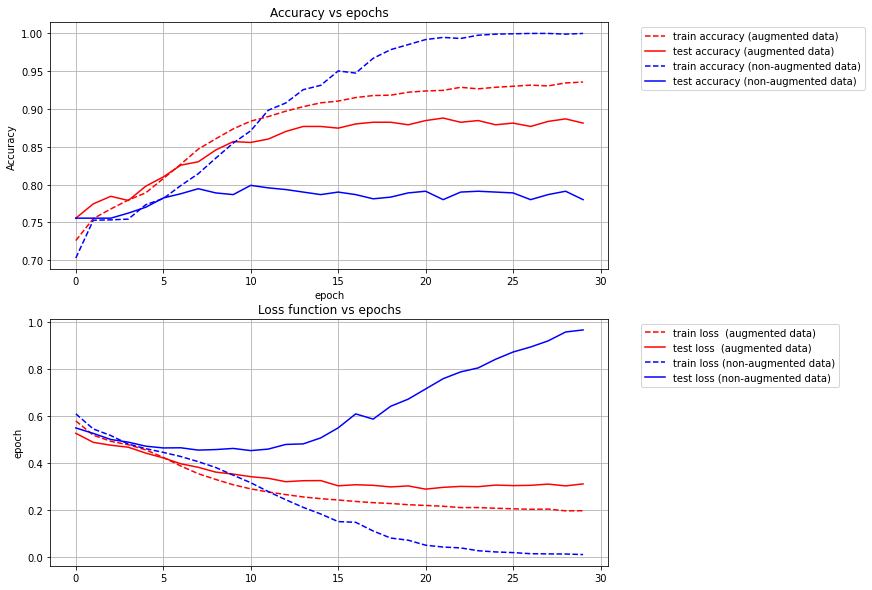

In [12]:
# look into training history
plt, ax = plt.subplots(2,1,figsize=(10,10))
#accuracy
ax[0].plot(fit_aug.history['accuracy'],
         label='train accuracy (augmented data)',
         c='red',
         ls='--'
        )
ax[0].plot(fit_aug.history['val_accuracy'],
         label='test accuracy (augmented data)',
         c='red'
        )
ax[0].plot(fit.history['accuracy'],
         label='train accuracy (non-augmented data)',
         c='blue',
         ls='--'
        )
ax[0].plot(fit.history['val_accuracy'],
         label='test accuracy (non-augmented data)',
         c='blue'
         )
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_title('Accuracy vs epochs')
ax[0].grid()
ax[0].legend(bbox_to_anchor=(1.05, 1))

#loss
ax[1].plot(fit_aug.history['loss'],
         label='train loss  (augmented data)',
         c='red',
         ls='--'
         )
ax[1].plot(fit_aug.history['val_loss'],
           label='test loss  (augmented data)',
           c='red'
           )
ax[1].plot(fit.history['loss'],
           label='train loss (non-augmented data)',
           c='blue',
           ls='--'
           )
ax[1].plot(fit.history['val_loss'],
           label='test loss (non-augmented data)',
           c='blue'
           )
ax[1].set_ylabel('Loss')
ax[1].set_ylabel('epoch')
ax[1].set_title('Loss function vs epochs')
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.05, 1))

plt.show()

As we can notice from the plot just above, enlarging the dataset helps us to avoid overfitting in 30 epochs and to achieve a higher test accuracy (in fact, the test and train results, retrieved by the network trained on the enlarged dataset, are closer). Therefore, we conclude that when enlarging the dataset, the prevalent effect is the increase in the number of useful training samples rather than the introduction of bad ones (label mistakenly associated). 


## Grid Search
We now implement a 'grid search' in order to tune the network parameters (keeping fixed its architecture).
Then we look for the optimal set including:
- the optimizer
- the activation function 
- the drop-out rate
- the batch size.
 

In [13]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='RMSprop', activation='relu', dropout_rate=0.2):
    # create model
    model_grid = Sequential()
    model_grid.add(Dense(L, input_shape=(L,), activation=activation))
    model_grid.add(Dense(L/2, activation=activation))
    model_grid.add(Dropout(dropout_rate))
    model_grid.add(Dense(1, activation=activation))

    model_grid.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy']
                      )
    return model_grid
 
# create model 
model_gridsearch = KerasClassifier(build_fn=create_model, 
                        epochs=30, 
                        batch_size=60,
                        verbose=0)

# list of allowed optional arguments for the optimizer, see compile_model()
optimizer = ['SGD', 'RMSprop', 'Adam']
activation = ['relu', 'elu', 'sigmoid', 'tanh']
dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
batch_size = [60, 300, 500]

learning_rate = [0.05, 0.1, 0.5]

# define parameter dictionary
param_grid = dict(optimizer     = optimizer,
                  dropout_rate  = dropout_rate,
                  activation    = activation,
                  batch_size = batch_size,
                  
                 )
# call scikit grid search module
grid = GridSearchCV(estimator = model_gridsearch,
                    param_grid = param_grid,
                    n_jobs = 1,
                    cv = 4,
                    verbose=0)
grid_result = grid.fit(np.asarray(x_train_augm),np.asarray(y_train_augm))

In [14]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.876488 using {'activation': 'relu', 'batch_size': 60, 'dropout_rate': 0.2, 'optimizer': 'RMSprop'}
0.373333 (0.219180) with: {'activation': 'relu', 'batch_size': 60, 'dropout_rate': 0.1, 'optimizer': 'SGD'}
0.868571 (0.013871) with: {'activation': 'relu', 'batch_size': 60, 'dropout_rate': 0.1, 'optimizer': 'RMSprop'}
0.851518 (0.010027) with: {'activation': 'relu', 'batch_size': 60, 'dropout_rate': 0.1, 'optimizer': 'Adam'}
0.508095 (0.253019) with: {'activation': 'relu', 'batch_size': 60, 'dropout_rate': 0.2, 'optimizer': 'SGD'}
0.876488 (0.008327) with: {'activation': 'relu', 'batch_size': 60, 'dropout_rate': 0.2, 'optimizer': 'RMSprop'}
0.851339 (0.011069) with: {'activation': 'relu', 'batch_size': 60, 'dropout_rate': 0.2, 'optimizer': 'Adam'}
0.500476 (0.253148) with: {'activation': 'relu', 'batch_size': 60, 'dropout_rate': 0.3, 'optimizer': 'SGD'}
0.863661 (0.007585) with: {'activation': 'relu', 'batch_size': 60, 'dropout_rate': 0.3, 'optimizer': 'RMSprop'}
0.843065 (0.017

## Rescale analysis

At first, we evaluate the performance of the best model trained on the original training set.
Then, we apply a rescaling to our data in order to have a zero-centered, unitary-variance set, to see if this leads to an improved performance.


Test loss: 0.7154310345649719
Test accuracy: 0.8422222137451172


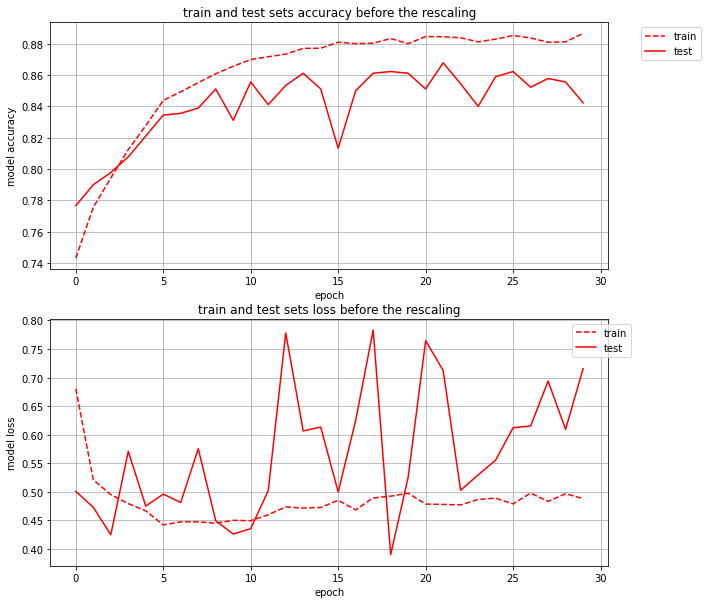

In [15]:
final_model = create_model(optimizer='RMSprop', activation='relu', dropout_rate=0.2) #Best model from GridSearch

from matplotlib import pyplot as plt

fit_final_model = final_model.fit(np.asarray(x_train_augm), np.asarray(y_train_augm),
                                  epochs = 30,
                                  batch_size=60,
                                  validation_data = (x_test, y_test),
                                  shuffle = True,
                                  verbose = 0                          
                                  )

score = final_model.evaluate(x_test, y_test, verbose=0)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])
fig, ax = plt.subplots(2,1,figsize=(10,10))
# accuracy
ax[0].plot(fit_final_model.history['accuracy'], ls='--', c='r')
ax[0].plot(fit_final_model.history['val_accuracy'], c='r')
ax[0].set_ylabel('model accuracy')
ax[0].set_xlabel('epoch')
ax[0].grid()
ax[0].legend(['train', 'test'], bbox_to_anchor=(1.05, 1))
ax[0].set_title('train and test sets accuracy before the rescaling')

# loss
ax[1].plot(fit_final_model.history['loss'], ls='--', c='r')
ax[1].plot(fit_final_model.history['val_loss'], c='r')
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].grid()
ax[1].legend(['train', 'test'], bbox_to_anchor=(1.05, 1))
ax[1].set_title('train and test sets loss before the rescaling')

plt.show()

In [16]:
#rescaling
x = np.concatenate((x_train_augm, x_test), axis=0)
mean = x.mean()
stdev = x.std()

x_train_augm = (x_train_augm - mean)/stdev 
x_test  = (x_test - mean) / stdev
print('mean', x_train_augm.mean())
print('stdev', x_train_augm.std())

mean -3.026405804203621e-17
stdev 1.0


In [17]:
final_model = create_model(optimizer='RMSprop', activation='relu', dropout_rate=0.2) #Best model from GridSearch
print(final_model.summary())

Model: "sequential_724"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2174 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_2175 (Dense)           (None, 32)                2080      
_________________________________________________________________
dropout_724 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_2176 (Dense)           (None, 1)                 33        
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________
None



Test loss: 0.6796478033065796
Test accuracy: 0.8744444251060486


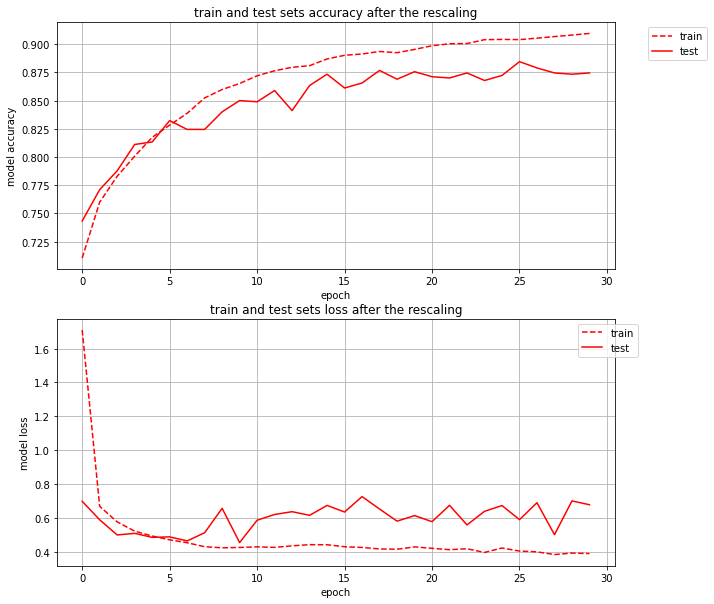

In [18]:
final_model = create_model(optimizer='RMSprop', activation='relu', dropout_rate=0.2) #Best model from GridSearch

from matplotlib import pyplot as plt

fit_final_model = final_model.fit(np.asarray(x_train_augm), np.asarray(y_train_augm),
                                  epochs = 30,
                                  batch_size=60,
                                  validation_data = (x_test, y_test),
                                  shuffle = True,
                                  verbose = 0                          
                                  )

score = final_model.evaluate(x_test, y_test, verbose=0)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])
fig, ax = plt.subplots(2,1,figsize=(10,10))
# accuracy
ax[0].plot(fit_final_model.history['accuracy'], ls='--', c='r')
ax[0].plot(fit_final_model.history['val_accuracy'], c='r')
ax[0].set_ylabel('model accuracy')
ax[0].set_xlabel('epoch')
ax[0].grid()
ax[0].legend(['train', 'test'], bbox_to_anchor=(1.05, 1))
ax[0].set_title('train and test sets accuracy after the rescaling')

# loss
ax[1].plot(fit_final_model.history['loss'], ls='--', c='r')
ax[1].plot(fit_final_model.history['val_loss'], c='r')
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].grid()
ax[1].legend(['train', 'test'], bbox_to_anchor=(1.05, 1))
ax[1].set_title('train and test sets loss after the rescaling')

plt.show()

## Appendix

# Trials with different cyclic translations
We now study the trade-off between data augmentation and wrong-labelled samples introduction.
In order to do this, we generate different training sets, starting from the original one and performing on it different 'partial' cyclic translations, that should reduce 
the wrong labelling.  
Then we compare the performances obtained on the test set for each training set.

In [19]:
shifting_list = [3, 7, 11, 15]

def shifting(x, positions, label):
    #function that shifts our strings
    shifted_x = []
    shifted_y =  []
    
    shifted_x.append(x)
    shifted_y.append(label)
    
    temp = x
    
    for j in range(positions):
        temp = temp[-1:]+temp[:-1]
        shifted_x.append(temp)
        shifted_y.append(label)
             
    return shifted_x, shifted_y

for shift in shifting_list:
    
    temp_x = []
    temp_y = []
    
    for i in range(len(sx_train)):
        temp_x += shifting(sx_train[i], shift, y_train[i])[0]
        temp_y += shifting(sx_train[i], shift, y_train[i])[1] 
    if shift == 3:
        sx_train_4 = temp_x
        y_train_4 = temp_y 
    if shift == 7:
        sx_train_8 = temp_x
        y_train_8  = temp_y 
    if shift == 11:
        sx_train_12 = temp_x
        y_train_12 = temp_y 
    if shift == 15:
        sx_train_16 = temp_x
        y_train_16 = temp_y 

In [20]:
np.random.seed(123)

model_shift = Sequential()
model_shift.add(Dense(L, input_shape=(L,), activation='relu'))
model_shift.add(Dense(L/2, activation='relu'))
model_shift.add(Dense(L/4, activation='relu'))
model_shift.add(Dropout(0.2))
model_shift.add(Dense(1, activation='sigmoid'))

print(model_shift.summary())

Model: "sequential_726"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2180 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_2181 (Dense)           (None, 32)                2080      
_________________________________________________________________
dense_2182 (Dense)           (None, 16)                528       
_________________________________________________________________
dropout_726 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_2183 (Dense)           (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None



Test loss: 0.5549190044403076
Test accuracy: 0.8711110949516296

Test loss: 0.7004770040512085
Test accuracy: 0.8688889145851135

Test loss: 0.9239717721939087
Test accuracy: 0.8877778053283691

Test loss: 1.090698003768921
Test accuracy: 0.8811110854148865


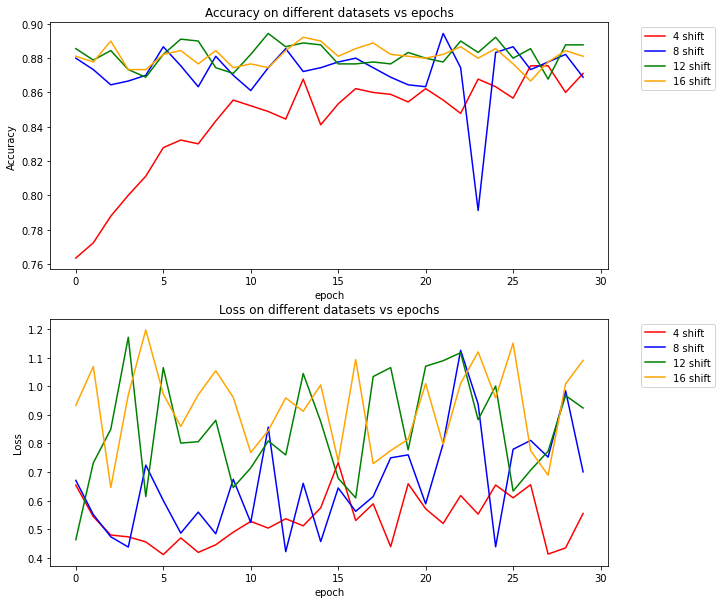

In [21]:
fig, ax = plt.subplots(2,1, figsize=(10,10))



shifted_x_list = [sx_train_4, sx_train_8, sx_train_12, sx_train_16]
shifted_y_list = [y_train_4, y_train_8, y_train_12, y_train_16]
batch_size = 60
color = ['red', 'blue', 'green', 'orange']

model_shift = create_model(optimizer='RMSprop', activation='relu', dropout_rate=0.2) #Best model from GridSearch


for i in range(len(shifted_x_list)):
    
    x_train = np.zeros((len(shifted_x_list[i]), L))
    
    for j in range(len(shifted_x_list[i])):
        for k in range(Ls):
            x_train[j][k*4 + onehc[shifted_x_list[i][j][k]]] = 1 #for every step in string you jump of 4 i the autoencpding

    


    model_shift.compile(loss='binary_crossentropy',
                    optimizer='RMSprop',
                    metrics=['accuracy'])
    
    fit_shift = model_shift.fit(np.asarray(x_train_augm), np.asarray(y_train_augm),
                                  epochs = 30,
                                  batch_size=batch_size,
                                  validation_data = (x_test, y_test),
                                  shuffle = True,
                                  verbose = 0                          
                                  )

    score = model_shift.evaluate(x_test, y_test, verbose=0)

    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    final = str(shifting_list[i]+1) + ' shift'
    final_2 = str(shifting_list[i]+1) + ' shift'
    ax[0].plot(fit_shift.history['val_accuracy'],
               label=final,
               c=color[i]
               )
    ax[0].set_title('Accuracy on different datasets vs epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(bbox_to_anchor=(1.05, 1))
    #ax[0].set_ylim(0.7,0.9)

    # summarize history for loss
    ax[1].plot(fit_shift.history['val_loss'],
               label=final_2,
               c=color[i])
    ax[1].set_title('Loss on different datasets vs epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(bbox_to_anchor=(1.05, 1))
    #ax[1].set_ylim(0.2,0.7)

As we can infer from the plots above, the performance increases with the number of generated samples. This highlights how the data augmentation technique turns out to be efficient: the increase of the number of good training samples prevales on the introduction of wronlgy-classified ones.